In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
#This function returns a lorenztian with one peak
def single_peak_lorentz(p,t):
    return  p[0]/(1 + ((t - p[1])/p[2])**2)

In [4]:
#This function computes the parital 
#derivatives for all the parameters of our one peak lorentzian
def analytic_diff(f,p,t):

    grad = np.zeros([t.size, p.size])

    grad[:,0] = 1.0/(1 + ((t - p[1])/p[2])**2)
    grad[:,1] = 2*p[0]*p[2]**2*(t-p[1])/((t - p[1])**2 + p[2]**2)**2
    grad[:,2] = 2*p[0]*p[2]*(t-p[1])**2/((t - p[1])**2 + p[2]**2)**2

    return grad

In [5]:
#This function returns the partials dev of any function
#It uses the central diff method 
def numerical_diff(f,p,t):
    

    #Setting the dx, note this is not the optimal way to set
    #the dx, but will do for this asgmt
    dx = t[1]-t[0]
    
    #This increment the parameter of interest by dx
    def T(f,p,t,i,dx):
        l = p.copy()
        l[i] += dx
        return f(l,t)

    grad = np.zeros([t.size, p.size])

    #computing the central difference
    for i in range(p.size):
         grad[:,i] = (T(f,p,t,i,dx)-T(f,p,t,i,-dx))/(2*dx)

    return grad

In [6]:
#This function returns the sum of three lorenztians
def triple_peak_lorentz(p,t):
    lorentz1 = p[0]/(1 + ((t - p[1])/p[2])**2)
    lorentz2 = p[3]/(1 + ((t - (p[1]-p[4]))/p[2])**2)
    lorentz3 = p[5]/(1 + ((t - (p[1]+p[4]))/p[2])**2)
    return lorentz1+lorentz2+lorentz3

In [7]:
#Newton methods 
def newton(f,diff_model,p0,t,d):
    p=p0.copy()
    for j in range(12):
        pred = f(p,t)
        grad=diff_model(f,p,t)
        r=d-pred
        err=(r**2).sum()
        r=np.matrix(r).transpose()
        grad=np.matrix(grad)

        lhs=grad.transpose()*grad
        rhs=grad.transpose()*r
        dp=np.linalg.inv(lhs)*(rhs)
        for jj in range(p.size):
            p[jj]=p[jj]+dp[jj]
    return p, np.linalg.inv(lhs)

In [8]:
def get_step(trial_step):
    if len(trial_step.shape)==1:
        return np.random.randn(len(trial_step))*trial_step
    else:
        L=np.linalg.cholesky(trial_step)
        return L@np.random.randn(trial_step.shape[0])

In [9]:
def mcmc(fun,p,trial_step,data,nstep=20000,T=1):
    npar=len(p)
    chain=np.zeros([nstep,npar])
    chisq=np.zeros(nstep)
    chain[0,:]=p
    chi_cur=fun(p,data)
    chisq[0]=chi_cur
    for i in range(1,nstep):
        pp=p+get_step(trial_step)
        pp = np.squeeze(np.asarray(pp))
        new_chisq=fun(pp,data)
        accept_prob=np.exp(-0.5*(new_chisq-chi_cur)/T)
        if np.random.rand(1)<accept_prob:
            p=pp
            chi_cur=new_chisq
        chain[i,:]=p
        chisq[i]=chi_cur
    return chain,chisq

In [10]:
def chisquare(y,pred,errs):
    return np.sum((pred-y)**2/errs**2)

In [11]:
def lorentz_chisq(p,data):
    t=data['t']
    d=data['d']
    errs=data['errs']

    pred=triple_peak_lorentz(p,t)
    chisq=np.sum((pred-d)**2/errs**2)
    return chisq

Question a) 

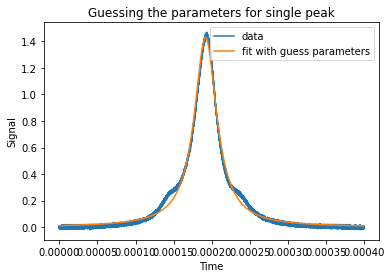

In [12]:
#Firs let's approximate the parameters with the 
#single peak lorentzian 
data = np.load('sidebands.npz')
t = data['time']
d = data['signal']

p0 = np.array([1.43e+00, 1.92e-04, 1.79e-05])

plt.plot(t,d, label="data")
plt.plot(t,single_peak_lorentz(p0, t), label="fit with guess parameters")
plt.title("Guessing the parameters for single peak")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()

[1.42281068e+00 1.92358649e-04 1.79236908e-05]


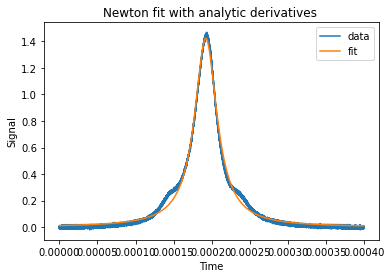

In [13]:
#Now let's fit with newton with the analytic deriv
params, M = newton(single_peak_lorentz,analytic_diff,p0,t,d)

print(params)
 
plt.plot(t,d, label="data")
plt.plot(t,single_peak_lorentz(params, t), label="fit")
plt.title("Newton fit with analytic derivatives ")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()


Question b)

For this question we first need to evaluate the noise. To do so I will look a the standard deviation at the end of the tails
which should be somewhat flat. Obviously that has a few issue. The first being that this assummes that the noise at the tails
is a good representation of the noise trouhought the data and is independent. Secondly, unlike a Gaussian it really takes a while
for a Lorentzian to go flat and I don't think our data really gets in the flat regime.

After that we can compute the error on the parameters taking the square root of the diagonal elements of the cov matix 

In [14]:
#Right tail
start_r = 0
end_r = 500
noise_r = np.std(d[start_r:end_r])

#Left tail
start_l = int(t.size-0.1*t.size)
end_l = t.size-1
noise_l = np.std(d[start_l:end_l])

#Will take the average of left and right for final noise
N = (noise_r+noise_r)/2

print("Noise at the right tail: N = ", noise_r)
print("Noise at the left tail: N = ", noise_l)
print("N =", N)
print("--------------------")

par_errs=np.sqrt(N*np.diag(M))

print("a =", params[0], "+/-", par_errs[0])
print("t0 =", params[1], "+/-", par_errs[1])
print("w =", params[2], "+/-", par_errs[2])

Noise at the right tail: N =  0.005258442584483227
Noise at the left tail: N =  0.0053169558408285795
N = 0.005258442584483227
--------------------
a = 1.422810680632242 +/- 0.0012227290776779494
t0 = 0.0001923586493756531 +/- 1.539865474479076e-08
w = 1.7923690794012613e-05 +/- 2.180644907287786e-08


Question c)


[1.42281068e+00 1.92358649e-04 1.79236908e-05]


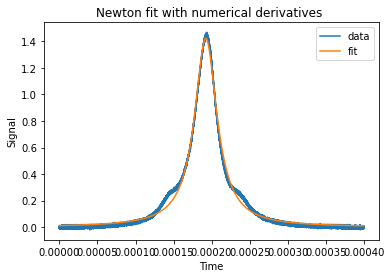

In [15]:
#Now let's fit with newton with the analytic deriv

p0 = np.array([1.43e+00, 1.92e-04, 1.79e-05])
params2, M2 = newton(single_peak_lorentz,numerical_diff, p0, t,d)

print(params2)
 
plt.plot(t,d, label="data")
plt.plot(t,single_peak_lorentz(params2, t), label="fit")
plt.title("Newton fit with numerical derivatives ")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()


In [16]:

par_errs2=np.sqrt(N*np.diag(M2))

print("a =", params2[0], "+/-", par_errs2[0])
print("t0 =", params2[1], "+/-", par_errs2[1])
print("w =", params2[2], "+/-", par_errs2[2])

a = 1.4228106808794694 +/- 0.0012227290598468593
t0 = 0.00019235864935751974 +/- 1.5398655122742105e-08
w = 1.7923690787766254e-05 +/- 2.1806449337134195e-08


To look at the how parameters computed with the numerical derivatives compares to the one computed with the analytic
derivatives I will look at the difference of the 2 divided by there error. If the ration is < 1 then clearly the difference
is not stastically different.

In [17]:
print("|a_anal-a_num|/err_a = ", np.abs(params[0]-params2[0])/par_errs[0])
print("|t0_anal-t0_num|/err_t0 = ", np.abs(params[1]-params2[1])/par_errs[1])
print("|w_anal-w_num|/err_w = ", np.abs(params[2]-params2[2])/par_errs[2])



|a_anal-a_num|/err_a =  2.0219307303372257e-07
|t0_anal-t0_num|/err_t0 =  1.1775939489855351e-06
|w_anal-w_num|/err_w =  2.864455256037595e-07


Question d)

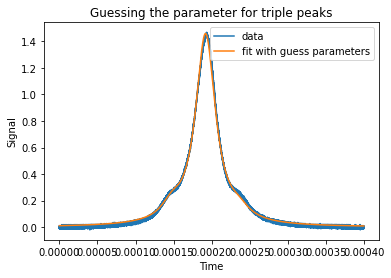

In [18]:
p0 = np.array([1.44e+00, 1.92e-04, 1.60e-05, 1.0391e-01,
 4.45e-05, 6.47e-02])

plt.plot(t,d, label="data")
plt.plot(t,triple_peak_lorentz(p0, t), label="fit with guess parameters")
plt.title("Guessing the parameter for triple peaks")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()

[1.44299240e+00 1.92578522e-04 1.60651094e-05 1.03910782e-01
 4.45671631e-05 6.47325303e-02]


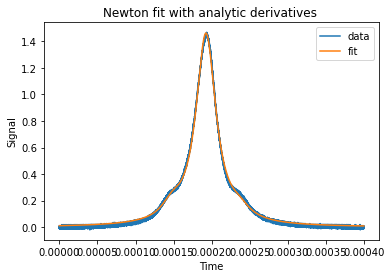

In [19]:
#Now let's fit with newton with the 3 peaks function

params, M = newton(triple_peak_lorentz,numerical_diff,p0,t,d)

print(params)
 
plt.plot(t,d, label="data")
plt.plot(t,triple_peak_lorentz(params, t), label="fit")
plt.title("Newton fit with analytic derivatives ")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()


In [20]:
par_errs=np.sqrt(N*np.diag(M))

print("a =", params[0], "+/-", par_errs[0])
print("t0 =", params[1], "+/-", par_errs[1])
print("w =", params[2], "+/-", par_errs[2])
print("b =", params[3], "+/-", par_errs[3])
print("dt =", params[4], "+/-", par_errs[4])
print("c =", params[5], "+/-", par_errs[5])

a = 1.4429923951207826 +/- 0.001325433500611828
t0 = 0.00019257852182477054 +/- 1.5692570325135306e-08
w = 1.6065109372447683e-05 +/- 2.810406319700809e-08
b = 0.10391078240616865 +/- 0.0012641839607202567
dt = 4.4567163132143084e-05 +/- 1.891765551331557e-07
c = 0.06473253030430412 +/- 0.0012378500935750973


Question e)

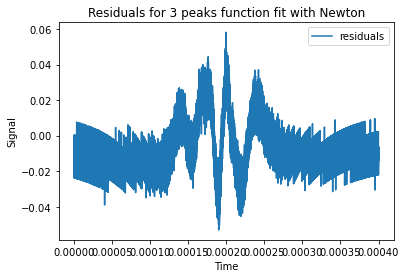

In [21]:
plt.plot(t,d-triple_peak_lorentz(params, t), label="residuals")
plt.title("Residuals for 3 peaks function fit with Newton")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()


As we can see the residuals have a lot of structure which means that functions is probably not an appriate description of the model and the noise migh not be independent

Question f)

133698.30473619708


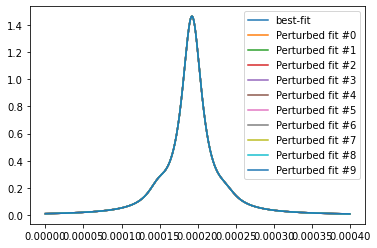

In [28]:
fit = triple_peak_lorentz(params, t)
error = np.mean(np.abs(d-fit))

best_fit_chi2 = chisquare(d,fit, error)
print(best_fit_chi2)
plt.plot(t,fit, label="best-fit")

n =10
pertubed_fit = np.empty((n,6))
pertubed_chi2 =np.empty(n)
for i in range(n):
    pp = np.random.multivariate_normal(params, N*M)
    pertubed_fit[i] = newton(triple_peak_lorentz,numerical_diff,pp,t,d)[0]
    fit = triple_peak_lorentz(pertubed_fit[i],t)
    pertubed_chi2[i] = chisquare(d,fit,error)
    plt.plot(t,fit, label="Perturbed fit #%i" %i)
plt.legend()


my best fit chi square is 133698.30473619708

In [23]:
print("Typical chi square difference= ", np.mean(np.abs(pertubed_chi2-best_fit_chi2)))

Typical chi square difference=  1.2223608791828156e-10


The typical difference between the best fit chi square and the pertubed chi square is 1.1641532182693481e-10.
This doesnt seem right to me but I don't see what I did wrong

In [24]:
stuff=np.load('sidebands.npz')
t=stuff['time']
d=stuff['signal']

noise=0.01
N=noise**2


p=np.asarray([1.44e+00, 1.92e-04, 1.60e-05, 1.0391e-01,
 4.45e-05, 6.47e-02])
 
fitp,curve=newton(triple_peak_lorentz,numerical_diff,p,t,d)
curve=curve*N #since we didn't include the noise in Newton's method
data={}
data['t']=t
data['d']=d
data['errs']=noise

chain, chivec = mcmc(lorentz_chisq,p,curve,data)

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_14948\134418668.py:12: RuntimeWarning: overflow encountered in exp
  accept_prob=np.exp(-0.5*(new_chisq-chi_cur)/T)


Text(0, 0.5, 'a')

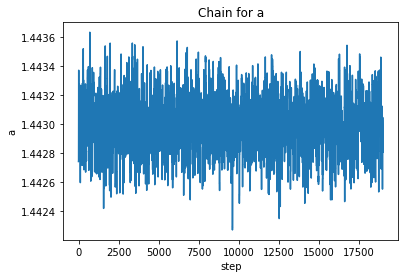

In [25]:
plt.plot(chain[:,0][1000:])
plt.title("Chain for a")
plt.xlabel("step")
plt.ylabel("a")

As we can see from the plot for the chain of the parameter a, the chain converged because it oscillating about a value and not moving around

In [26]:
#Error newton vs error mcmc
print("Error with newton on a=", par_errs[0],", Error with mcmc on a=", np.std(chain[:,0][1000:]))
print("Error with newton on t0=", par_errs[1],", Error with mcmc on t0=", np.std(chain[:,1][1000:]))
print("Error with newton on w=", par_errs[2],", Error with mcmc on w=", np.std(chain[:,2][1000:]))
print("Error with newton on b=", par_errs[3],", Error with mcmc on b=", np.std(chain[:,3][1000:]))
print("Error with newton on dt=", par_errs[4],", Error with mcmc on dt=", np.std(chain[:,4][1000:]))
print("Error with newton on c=", par_errs[5],", Error with mcmc on dt=", np.std(chain[:,0][1000:]))

Error with newton on a= 0.001325433500611828 , Error with mcmc on a= 0.0001812509895275431
Error with newton on t0= 1.5692570325135306e-08 , Error with mcmc on t0= 2.20043075947428e-09
Error with newton on w= 2.810406319700809e-08 , Error with mcmc on w= 3.697798053711341e-09
Error with newton on b= 0.0012641839607202567 , Error with mcmc on b= 0.00017478817074383814
Error with newton on dt= 1.891765551331557e-07 , Error with mcmc on dt= 2.4066000571585905e-08
Error with newton on c= 0.0012378500935750973 , Error with mcmc on dt= 0.0001812509895275431


As we can see the error is considerably lower with the mcmc

Question h

First let's do some dimensional analysis 

[dt] = T where T stands for time
[seperation] = T^-1
[w] = T

We know that our answer has dimension T^-1, so

[dt]^a[seperation]^b[w]^c = T

=> T^a.T^-b.T^c = T^-1

the obbvious solution is a = b = 1 and c = -1

which gives dt/w*9Ghz

In [27]:
dt = np.std(chain[:,4][1000:])
w = np.std(chain[:,2][1000:])

width = dt/w*9

print("The cavity width is", width, "Ghz")

The cavity width is 58.573778772717425 Ghz
